Initial Data Info:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043

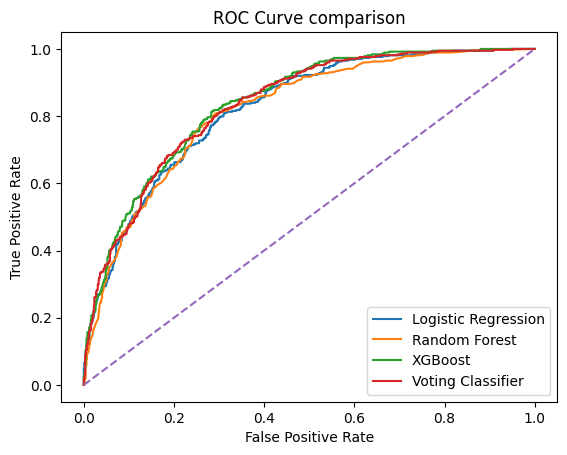

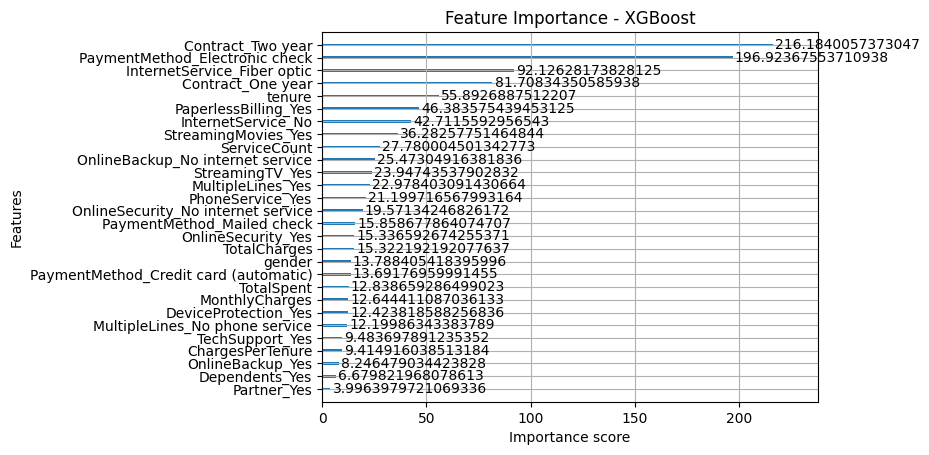

['model.pkl']

In [4]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from imblearn.over_sampling import SMOTE
import xgboost as xgb
from sklearn.metrics import (
    roc_auc_score, roc_curve, accuracy_score,
    classification_report, confusion_matrix, f1_score, recall_score, precision_score
)
import joblib
from sklearn.preprocessing import StandardScaler


# 1. Load dataset

url = "https://raw.githubusercontent.com/sharma0864/Churn-ML-Project/refs/heads/main/data/Telco-Customer-Churn.csv"
df = pd.read_csv(url)


# 2. Data Cleaning

print("Initial Data Info:\n")
print(df.info())
print(df.describe())
print(df.head())


print("\nMissing values before cleaning:\n", df.isnull().sum())
df.dropna(inplace=True)

print("\nDuplicate rows:", df.duplicated().sum())
df.drop_duplicates(inplace=True)
df.drop('customerID', axis=1, inplace=True)


# 3. Convert categorical to numeric

# Convert gender to binary
df['gender'] = df['gender'].map({'Male': 0, 'Female': 1})

# Convert TotalCharges to numeric
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
df.dropna(inplace=True)

# Convert text columns into indicator (binary) columns so machine learning models can use them
df = pd.get_dummies(df, drop_first=True)


# 4. Feature Engineering

# TotalSpent: The total amount a customer has paid so far .
df['TotalSpent'] = df['tenure'] * df['MonthlyCharges']

# ServiceCount: The number of services a customer is using. More services usually means less chance of leaving.
df['ServiceCount'] = (
    df[['PhoneService_Yes', 'InternetService_Fiber optic',
        'StreamingTV_Yes', 'StreamingMovies_Yes']].sum(axis=1))

# ChargesPerTenure: The average charge per month for each customer.
# This helps see if someone is on a cheap or expensive plan, which can affect churn
df['ChargesPerTenure'] = df['TotalCharges'] / (df['tenure'] + 1)


# 5. Split data

X = df.drop('Churn_Yes', axis=1)
y = df['Churn_Yes']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Scale numerical features
numerical_cols = ['tenure', 'MonthlyCharges', 'TotalCharges', 'TotalSpent', 'ServiceCount', 'ChargesPerTenure']
scaler = StandardScaler()
X_train[numerical_cols] = scaler.fit_transform(X_train[numerical_cols])
X_test[numerical_cols] = scaler.transform(X_test[numerical_cols])

# 5. Apply SMOTE to handle imbalance
print("\nBefore SMOTE:", y_train.value_counts())
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

print("After SMOTE:", y_train_res.value_counts())

# 6.Build Multiple Models

# Logistic Regression
logreg= LogisticRegression(max_iter=5000)
logreg.fit(X_train_res,y_train_res)

# Random Forest
rf=RandomForestClassifier(n_estimators=200, random_state=42)
rf.fit(X_train_res,y_train_res)
#XGBoost
xgb_model= xgb.XGBClassifier(
      eval_metric='logloss',
      n_estimators=100,
      learning_rate=0.05,
      max_depth=3,
      subsample=0.8,
      colsample_bytree=0.8
      )
xgb_model.fit(X_train_res,y_train_res)


#7.Train model
models={"Logistic Regression":logreg,
        "Random Forest": rf,
        "XGBoost": xgb_model
}

def evaluate_model(name,model,X_test,y_test):
  y_pred=model.predict(X_test)
  y_pred_proba=model.predict_proba(X_test)[:,1]

  acc= accuracy_score(y_test, y_pred)
  f1= f1_score(y_test, y_pred)
  rec= recall_score(y_test, y_pred)
  prec=precision_score(y_test, y_pred)
  auc = roc_auc_score(y_test, y_pred_proba)

  print(f"\n{name} Results:")
  print("Accuracy:", acc)
  print("AUC:", auc)
  print("Recall:", rec)
  print("Precision:", prec)
  print("F1 Score:", f1)
  # Convert predicted probabilities to binary labels for confusion matrix
  y_pred_binary = (y_pred_proba > 0.5).astype(int)
  print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_binary))
  return[name,acc,auc,rec,prec,f1]

#8. Results in a table
results=[]
results.append(evaluate_model("Logistic Regression", logreg, X_test, y_test))
results.append(evaluate_model("Random Forest", rf, X_test, y_test))
results.append(evaluate_model("XGBoost", xgb_model, X_test, y_test))


#Voting classifier
voting_clf=VotingClassifier(
    estimators=[('lr',logreg),('rf',rf), ('xgb',xgb_model)],
    voting='soft'
)
voting_clf.fit(X_train_res, y_train_res)
results.append(evaluate_model("Voting Classifier", voting_clf, X_test, y_test))

# 9. Create comparison table
results_df=pd.DataFrame(results,columns=["Model", "Accuracy", "AUC", "Recall", "Precision", "F1 Score"])
print("\nComparison of all models:\n",results_df)
best_model_name = results_df.loc[results_df["AUC"].idxmax()]["Model"]
best_model = models[best_model_name] # Corrected assignment

print("\nBest Model:\n", results_df.loc[results_df["AUC"].idxmax()])

#Plot ROC Curve for all  model
for model, name in zip([logreg,rf,xgb_model,voting_clf],
                      ["Logistic Regression","Random Forest","XGBoost","Voting Classifier"]):
 y_pred_proba=model.predict_proba(X_test)[:,1]
 fpr,tpr,_=roc_curve(y_test,y_pred_proba)
 auc=roc_auc_score(y_test,y_pred_proba)
 plt.plot(fpr,tpr,label=name )
plt.plot([0,1],[0,1],linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve comparison")
plt.legend()
plt.show()

xgb.plot_importance(best_model, importance_type='gain')
plt.title("Feature Importance - XGBoost")
plt.show()

joblib.dump(model, 'model.pkl')